# Table of Contents
 <p><div class="lev1"><a href="#Metadata-QC:-Full-database-checks">Metadata QC: Full database checks</a></div><div class="lev1"><a href="#1.-Summary">1. Summary</a></div><div class="lev1"><a href="#2.-Elevation-QC-check">2. Elevation QC check</a></div><div class="lev2"><a href="#Overall-stats">Overall stats</a></div><div class="lev2"><a href="#Histogram-of-elevation-flags-distribution">Histogram of elevation flags distribution</a></div><div class="lev2"><a href="#Map-of-ACTIVE-flagged-data,-colored-by-elevation-difference">Map of ACTIVE flagged data, colored by elevation difference</a></div><div class="lev2"><a href="#Possible-sources-of-bad-elevation-metadata">Possible sources of bad elevation metadata</a></div><div class="lev3"><a href="#Elevation-metadata-in-meters">Elevation metadata in meters</a></div><div class="lev2"><a href="#Flagged-stations-by-network">Flagged stations by network</a></div><div class="lev1"><a href="#3.-Low-precision-lat-/-lon">3. Low precision lat / lon</a></div><div class="lev1"><a href="#4.-'None'-metadata">4. 'None' metadata</a></div><div class="lev1"><a href="#5.-Outlier-stations">5. Outlier stations</a></div>

In [252]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="View raw code"></form>''')

Use toggle button to view raw code if desired.

In [253]:
%matplotlib inline

# Metadata QC: Full database checks

**Patrick Wright, *Synoptic Data***

**July 27, 2018**

# 1. Summary

This notebook contains initial analysis of metadata checks for the database backing the Mesonet API. These checks are run with the script 'metadata_check_fullDB.py' found in the 'metadata-qc' repo in GitHub. The script is intended to be run manually on the entire database. There is an additional script ('elev_metadata.py') that runs as a daily cron job to check metadata for any new or relocated stations.

* Metadata is read from the CHPC MySQL database (db='metamoth').
* Uses the xcskies API to access SRTM v4 DEM data (example: https://dev3.xcskies.com/elevation?lats=32.3776&lons=-111.0700 ). The DEM is 30-m resolution for lat <= 60 N, and 90-m resolution for lat > 60 N. The API response is returned in meters. All metadata elevations and DEM elevations are reported in feet in the flag output.
* Only one station in the database is outside the bounds of the DEM area (stid=SCOA6, Scott Base, Antarctica). This station was removed from the checklist.
* Elevation threshold set at 200 ft.
* The following checks are performed on the database:
    * 'None' check. If 'None' entries are found for any metadata, they are reported and the station is removed from the checklist.
    * lat / lon precision check. If lat / lon has < 3 decimal places, the station is reported and remains on the checklist.
    * Elevation check. Using lat / lon metadata, DEM elevation is compared to metadata elevation. Stations are flagged if difference is greater than defined threshold.
* The QC flags analyzed here are only valid for database entries through 7/27/2018.



# 2. Elevation QC check

## Overall stats

(elevation flagging threshold = 200')

**Number of flagged stations: 3591 of 69556 (5.2%)**

**Number of 'ACTIVE' flagged stations: 1923 of 3591 (53.6% of flagged, 2.8% of all stations)**

**Stations with low-precision latitude: 9197 (ACTIVE: 6896)**

**Stations with low-precision longitude: 9161 (ACTIVE: 6891)**

**Stations with 'None' elevation: 412 (ACTIVE: 149)** 

## Histogram of elevation flags distribution
The histogram of the elevation flags distribution has tails extending to almost (+/-) 30,000'. To better see the distribution of the core of the flag data, 96 stations with elevation differences > (+/-) 5000' are not shown in the histogram below. **See the bottom of this notebook for a list of outlier stations.**

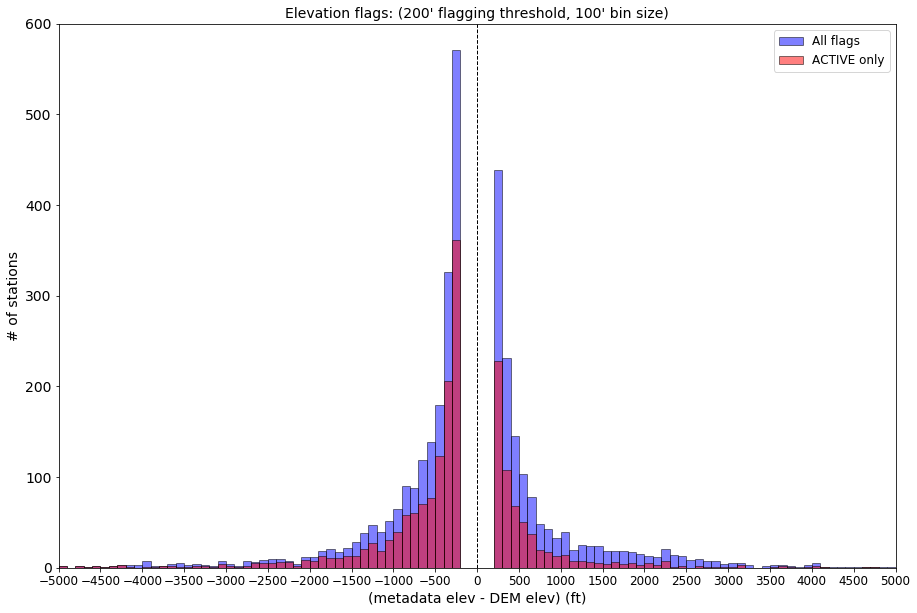

In [254]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

elev_flag = pd.read_csv('csv_output/elev_flag.csv', sep=',', header=0)

hi = elev_flag[elev_flag.elev_diff > 5000]
lo = elev_flag[elev_flag.elev_diff < -5000]

outliers = pd.concat([hi,lo])
outliers_sort_elev = outliers.sort_values(by='elev_diff', ascending=True)
outliers_sort_MNET_ID = outliers.sort_values(by='MNET_ID', ascending=True)

elev_flag_limited = elev_flag[(elev_flag.elev_diff <= 5000) & (elev_flag.elev_diff >= -5000)]
elev_flag_limited_active = elev_flag[(elev_flag.elev_diff <= 5000)
                                     & (elev_flag.elev_diff >= -5000)
                                     & (elev_flag.STATUS == 'ACTIVE')]

bin_range_1 = range(-5000,5100,100)

fig1 = plt.figure(figsize=(15, 10))
ax1 = fig1.add_subplot(111)
n, bins, patches = plt.hist(elev_flag_limited.elev_diff, bins=bin_range_1,
                            facecolor='blue', edgecolor='black', alpha=0.5, label='All flags')
n, bins, patches = plt.hist(elev_flag_limited_active.elev_diff, bins=bin_range_1,
                            facecolor='red', edgecolor='black', alpha=0.5, label='ACTIVE only')
plt.axvline(x=0, linewidth=1, linestyle='--', color='k')
ax1.set_title("Elevation flags: (200' flagging threshold, 100' bin size)", fontsize=14)
ax1.set_xlabel('(metadata elev - DEM elev) (ft)', fontsize=14)
ax1.set_ylabel('# of stations', fontsize=14)
ax1.set_xlim([-5000, 5000])
plt.xticks(np.arange(-5000, 5500, 500))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)
plt.show()

## Map of ACTIVE flagged data, colored by elevation difference
'ACTIVE' flagged data, where markers are colored by the absolute value of (metadata elev - DEM elev). Dataset is ordered so that high-error values (red) are plotted on top. Diff values >1000' receive max red color.

There seem to be no obvious geographic patterns to the high-error metadata.

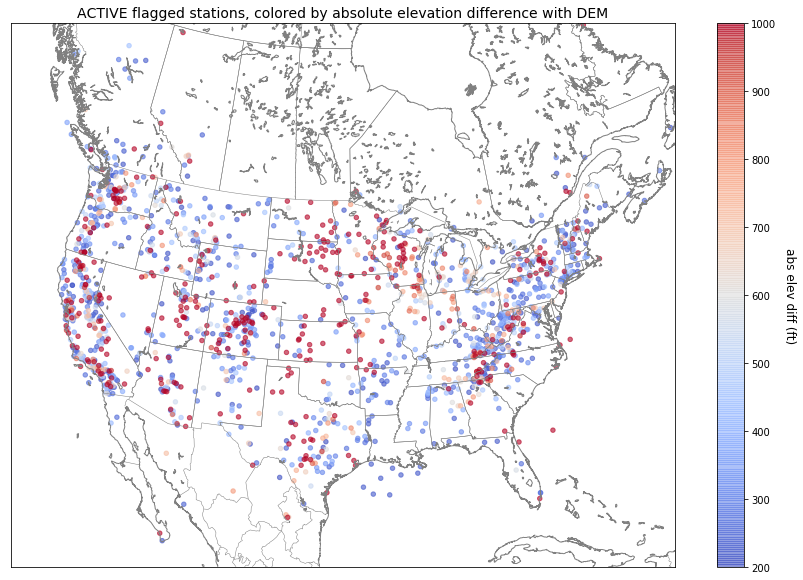

In [255]:
elev_flag_active = elev_flag[elev_flag.STATUS=='ACTIVE']
#elev_flag_active['abs_diff'] = abs(elev_flag_active.elev_diff) # This throws warning
elev_flag_active.loc[:,'abs_diff'] = abs(elev_flag_active.elev_diff)
sorted_diff = elev_flag_active.sort_values(by='abs_diff', ascending=True)

# Draw North America map background:
fig = plt.figure(figsize=(15, 10))
m = Basemap(projection='lcc', resolution='i', 
            lat_0=42, lon_0=-96,
            width=5.5E6, height=4.5E6)

#m.shadedrelief()
#m.drawrivers(color='blue')
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

#parallels = np.arange(0.,90,10.)
#m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
#meridians = np.arange(180.,360.,10.)
#m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

# Scatter the lat / lon:
sc = m.scatter(np.array(sorted_diff.lon), np.array(sorted_diff.lat),
          s=20, latlon=True, alpha=0.6, vmin=200, vmax=1000, 
          c=np.array(sorted_diff.abs_diff),
          cmap=plt.get_cmap("coolwarm"))

cbar = plt.colorbar(sc)

cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel('abs elev diff (ft)', rotation=270, fontsize=12)

plt.title('ACTIVE flagged stations, colored by absolute elevation difference with DEM', fontsize=14)
plt.show()

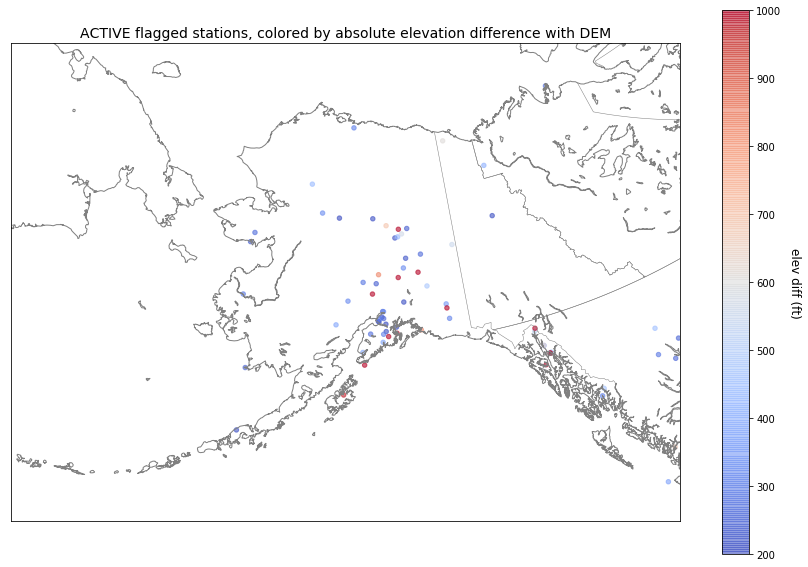

In [256]:
# Draw AK map background:
fig = plt.figure(figsize=(15, 10))
m = Basemap(projection='lcc', resolution='i', 
            lat_0=63, lon_0=-153,
            width=3.5E6, height=2.5E6)

#m.shadedrelief()
#m.drawrivers(color='blue')
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

#parallels = np.arange(0.,90,10.)
#m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
#meridians = np.arange(180.,360.,10.)
#m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)


# Scatter the lat / lon:
sc = m.scatter(np.array(sorted_diff.lon), np.array(sorted_diff.lat),
          s=20, latlon=True, alpha=0.6, vmin=200, vmax=1000, 
          c=np.array(sorted_diff.abs_diff), cmap=plt.get_cmap("coolwarm"))

cbar = plt.colorbar(sc)

cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel('elev diff (ft)', rotation=270, fontsize=12)

plt.title('ACTIVE flagged stations, colored by absolute elevation difference with DEM', fontsize=14)
plt.show()

## Possible sources of bad elevation metadata

**467 flagged stations (304 ACTIVE) have metadata elevation = 0.0.** Plotting only these stations, we can see that these metadata values are likely bad:

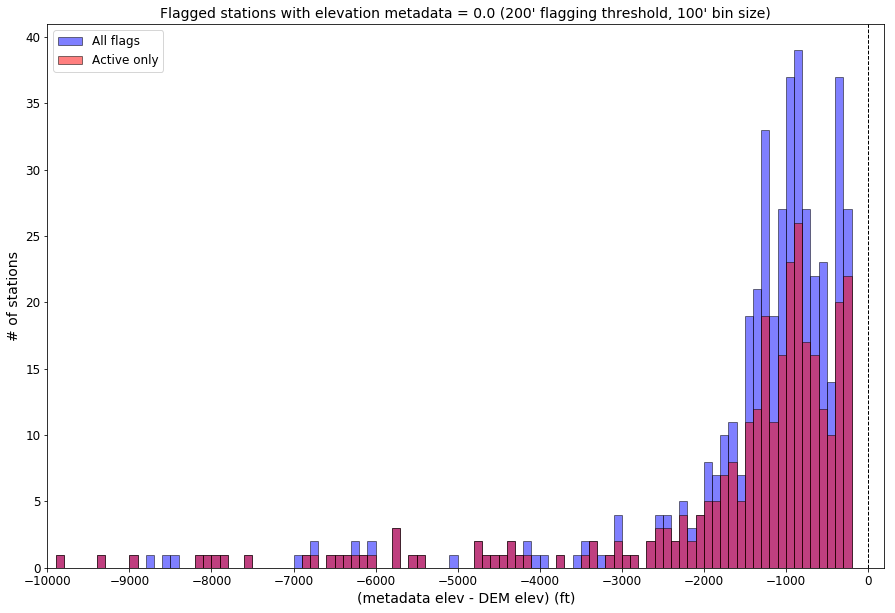

In [257]:
zero_elev = elev_flag[(elev_flag['elev'] == 0)]
zero_elev_active = elev_flag[(elev_flag['elev'] == 0) & (elev_flag['STATUS'] == 'ACTIVE')]

bin_range_1 = range(-10000,100,100)

fig2 = plt.figure(figsize=(15, 10))
ax1 = fig2.add_subplot(111)
n, bins, patches = plt.hist(zero_elev.elev_diff, bins=bin_range_1,
                            facecolor='blue', edgecolor='black', alpha=0.5, label='All flags')
n, bins, patches = plt.hist(zero_elev_active.elev_diff, bins=bin_range_1,
                            facecolor='red', edgecolor='black', alpha=0.5, label='Active only')
plt.axvline(x=0, linewidth=1, linestyle='--', color='k')
ax1.set_title("Flagged stations with elevation metadata = 0.0 (200' flagging threshold, 100' bin size)", fontsize=14)
ax1.set_xlabel('(metadata elev - DEM elev) (ft)', fontsize=14)
ax1.set_ylabel('# of stations', fontsize=14)
ax1.set_xlim([-10000, 200])
plt.xticks(np.arange(-10000, 100, 1000))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.show()

### Elevation metadata in meters

The negative skew of the first histogram (all flagged stations) indicates a bias towards stations with metadata elevation less than DEM elevation. One possible reason is **metadata elevation entered in meters**, which (even if a correct elevation) will always result in negative values for (DEM - metadata). Below, I drop any 0.0 values, and then calculate the ratio of (DEM elev / metadata elev) and plot the distribution:

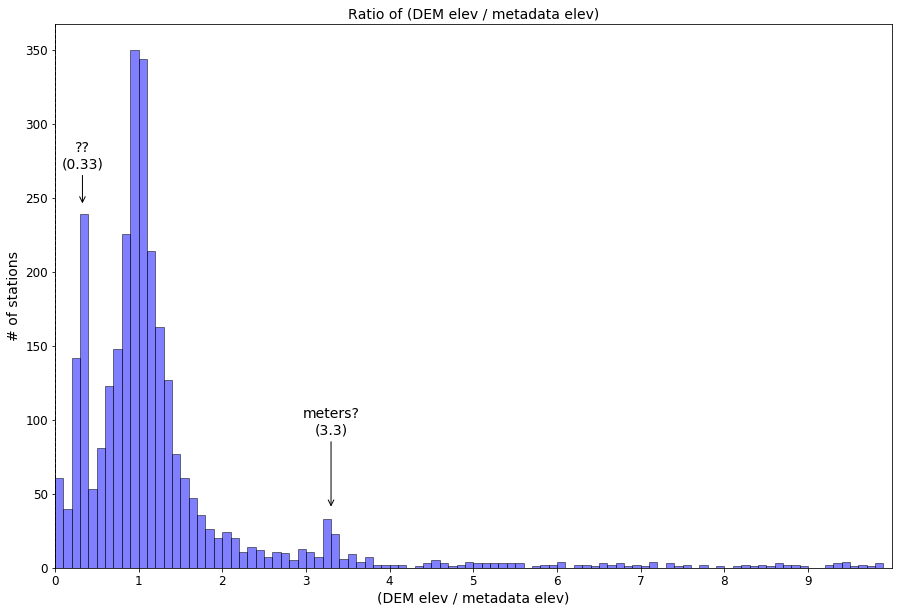

In [258]:
# drop any entries with elev metadata = 0:
elev_flag_dropzero = elev_flag[~(elev_flag['elev'] == 0.)]

# drop any entries with DEM = 0:
elev_flag_dropzero = elev_flag_dropzero[~(elev_flag_dropzero['DEM_elev'] == 0.)]

ratio =  (elev_flag_dropzero.DEM_elev) / (elev_flag_dropzero.elev) # DEM / metadata
#ratio =  (elev_flag_dropzero.elev / elev_flag_dropzero.DEM_elev) # metadata / DEM

bin_range_1 = np.arange(0, 10, .1)

fig3 = plt.figure(figsize=(15, 10))
ax1 = fig3.add_subplot(111)
n, bins, patches = plt.hist(ratio, bins=bin_range_1, facecolor='blue', edgecolor='black', alpha=0.5)
plt.axvline(x=0, linewidth=1, linestyle='--', color='k')
ax1.set_title("Ratio of (DEM elev / metadata elev)", fontsize=14)
ax1.set_xlabel('(DEM elev / metadata elev)', fontsize=14)
ax1.set_ylabel('# of stations', fontsize=14)
ax1.set_xlim([0, 10])
plt.xticks(np.arange(0, 10, 1))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.annotate(
    'meters?\n(3.3)',
    xy=(3.3, 40),
    xycoords='data',
    xytext=(3.3, 90),
    textcoords='data',
    fontsize=14,
    horizontalalignment='center',
    arrowprops=dict(facecolor='black', arrowstyle="->")
)

plt.annotate(
    '??\n(0.33)',
    xy=(0.33, 245),
    xycoords='data',
    xytext=(0.33, 270),
    textcoords='data',
    fontsize=14,
    horizontalalignment='center',
    arrowprops=dict(facecolor='black', arrowstyle="->")
)
plt.show()


The main distribution between ~0.0 - 2.0 results from the overall distribution for the flagged station metadata, where (for example) a station with (DEM elev = 3300') and (metadata elev = 3550') is flagged (> 200 ft threshold) and has a ratio of 0.93. An odd spike occurs at ~0.33, which would result from metadata elev that is 3.3x DEM elev. What is causing this?? The small spike at 3.3 would indicate metadata entered in meters. **Zooming in on the area between 3.2-3.4...**

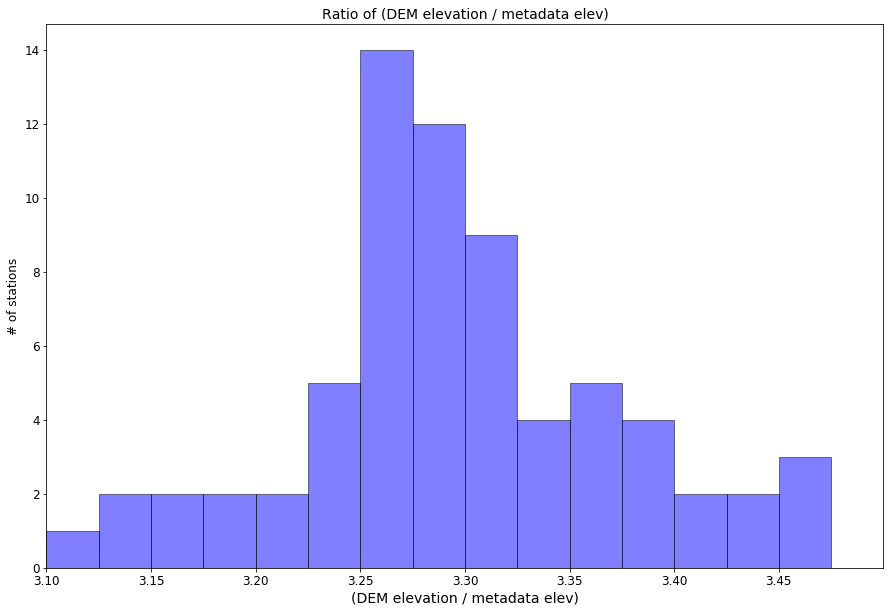

In [259]:
bin_range_1 = np.arange(3.1, 3.5, .025)

fig4 = plt.figure(figsize=(15, 10))
ax1 = fig4.add_subplot(111)
n, bins, patches = plt.hist(ratio, bins=bin_range_1, facecolor='blue', edgecolor='black', alpha=0.5)
plt.axvline(x=0, linewidth=1, linestyle='--', color='k')
ax1.set_title("Ratio of (DEM elevation / metadata elev)", fontsize=14)
ax1.set_xlabel('(DEM elevation / metadata elev)', fontsize=14)
ax1.set_ylabel('# of stations', fontsize=12)
ax1.set_xlim([3.1, 3.5])
plt.xticks(np.arange(3.1, 3.5, .05))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

A ratio of 3.28 would indicate the exact ratio for DEM (in ft) and metadata (in meters). This seems to indicate that **elevation metadata has been entered in meters for ~40 stations (not very many).**

Limiting stations for ratios between 3.23 - 3.33 (39 stations), we can map them and see if there are any geographic patterns. I predicted that this might be a problem common to Canadian networks, but looks like I'm wrong!

This analysis is not very conclusive, so perhaps there is less metadata entry in meters than I previously thought...

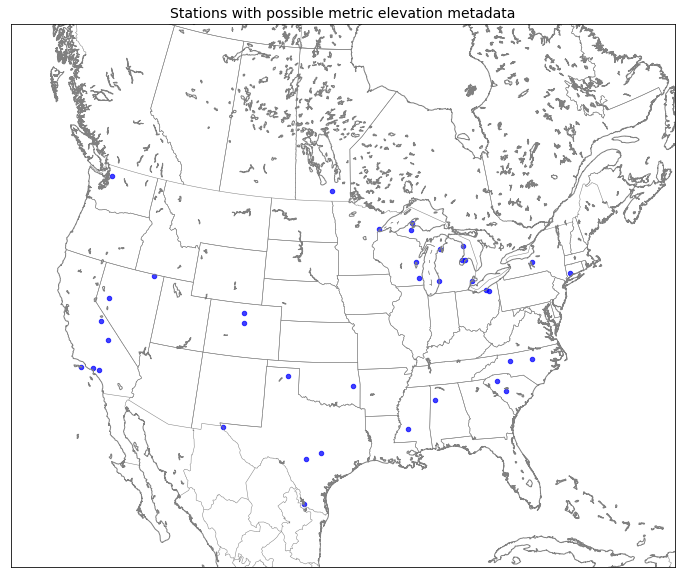

In [260]:
efd = elev_flag_dropzero
metrics = efd[((efd.DEM_elev / efd.elev) > 3.23) & ((efd.DEM_elev / efd.elev) < 3.33)]

# Draw North America map background:
fig = plt.figure(figsize=(15, 10))
m = Basemap(projection='lcc', resolution='i', 
            lat_0=42, lon_0=-96,
            width=5.5E6, height=4.5E6)

#m.shadedrelief()
#m.drawrivers(color='blue')
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

#parallels = np.arange(0.,90,10.)
#m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
#meridians = np.arange(180.,360.,10.)
#m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)


# Scatter the lat / lon:
m.scatter(np.array(metrics.lon), np.array(metrics.lat),
          latlon=True, color='b', alpha=0.75, s=20)

plt.title('Stations with possible metric elevation metadata', fontsize=14)
plt.show()


## Flagged stations by network

The following histogram displays totals for the complete elevation flag output.

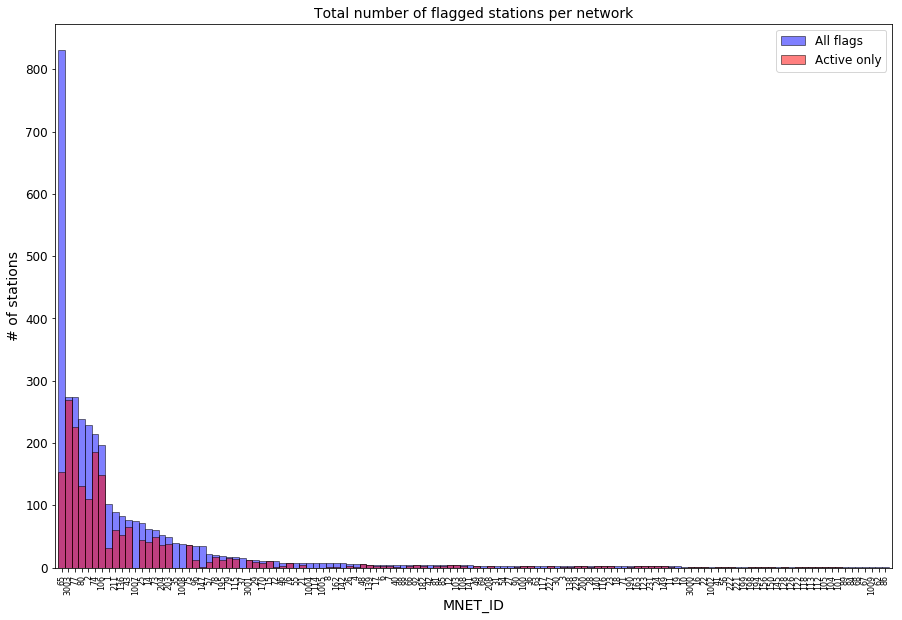

In [261]:
network_flags = elev_flag.groupby(['MNET_ID','SHORTNAME']).MNET_ID.count().sort_values(ascending=False)
network_flags.rename('network_flags', inplace=True)
network_flags = network_flags.reset_index(name='flag_count')
network_flags.MNET_ID = network_flags.MNET_ID.apply(str)

elev_flag_active = elev_flag[elev_flag.STATUS=='ACTIVE']

network_flags_active = elev_flag_active.groupby(['MNET_ID','SHORTNAME']).MNET_ID.count().sort_values(ascending=False)
network_flags_active.rename('network_flags_active', inplace=True)
network_flags_active = network_flags_active.reset_index(name='flag_count')
network_flags_active.MNET_ID = network_flags_active.MNET_ID.apply(str)

fig5 = plt.figure(figsize=(15, 10))
ax1 = fig5.add_subplot(111)
bars_1 = ax1.bar(network_flags.MNET_ID, network_flags.flag_count,
               1, edgecolor='k', alpha=0.5, color='b', label='All flags')
bars_2 = ax1.bar(network_flags_active.MNET_ID, network_flags_active.flag_count,
               1, edgecolor='k', alpha=0.5, color='r', label='Active only')
ax1.set_xlabel('MNET_ID', fontsize=14)
ax1.set_ylabel('# of stations', fontsize=14)
ax1.set_title('Total number of flagged stations per network', fontsize=14)
ax1.set_xlim([-1, len(network_flags)])
plt.xticks(fontsize=8)
plt.yticks(fontsize=12)
plt.xticks(rotation=90)
plt.legend(fontsize=12)
plt.show()

Limiting to networks with 10 flagged stations or greater:

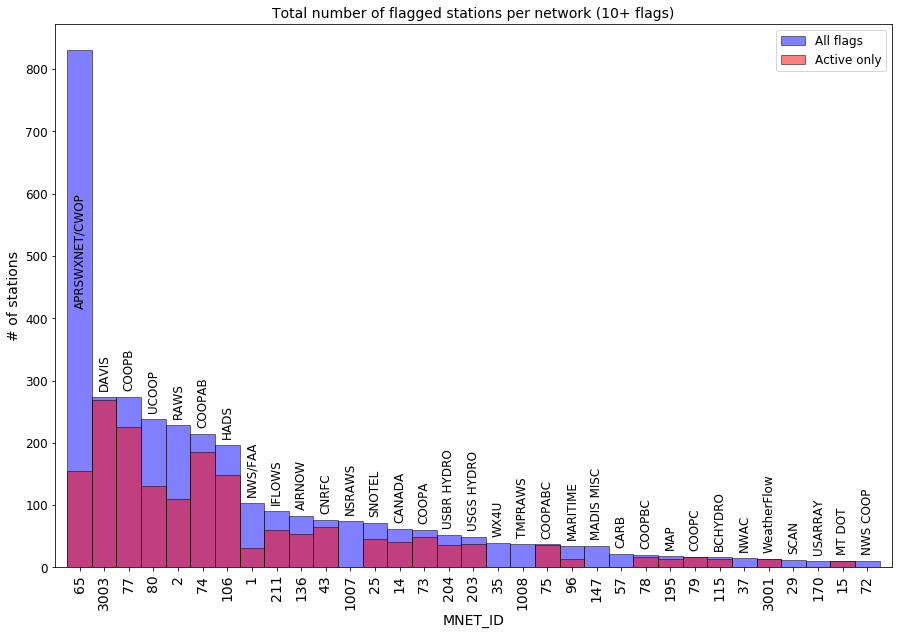

In [262]:
network_flags_limited = network_flags[network_flags.flag_count > 9]
network_flags_active_limited = network_flags_active[network_flags_active.flag_count > 9]

def autolabel_midfirst(bars):
    """
    Attach a text label above each bar displaying SHORTNAME
    """
    index_pos=0
    for bar in bars:
        label = network_flags_limited.SHORTNAME[index_pos]
        height = bar.get_height()
        if index_pos==0:
            ax1.text(bar.get_x() + bar.get_width()/2., 0.5*height,
                     '%s' % label,
                     ha='center', va='bottom', rotation=90, fontsize=12)
        else:
            ax1.text(bar.get_x() + bar.get_width()/2., (height+10),
                    '%s' % label,
                    ha='center', va='bottom', rotation=90, fontsize=12)
        index_pos = index_pos + 1

fig6 = plt.figure(figsize=(15, 10))
ax1 = fig6.add_subplot(111)
bars_1 = ax1.bar(network_flags_limited.MNET_ID, network_flags_limited.flag_count,
               1, edgecolor='k', alpha=0.5, color='b', label='All flags')
bars_2 = ax1.bar(network_flags_active_limited.MNET_ID, network_flags_active_limited.flag_count,
               1, edgecolor='k', alpha=0.5, color='r', label='Active only')
ax1.set_xlabel('MNET_ID', fontsize=14)
ax1.set_ylabel('# of stations', fontsize=14)
ax1.set_title('Total number of flagged stations per network (10+ flags)', fontsize=14)
ax1.set_xlim([-1, len(network_flags_limited)])
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(rotation=90)
plt.legend(fontsize=12)
        
autolabel_midfirst(bars_1)
        
plt.show()

Limiting to only 'ACTIVE' stations:

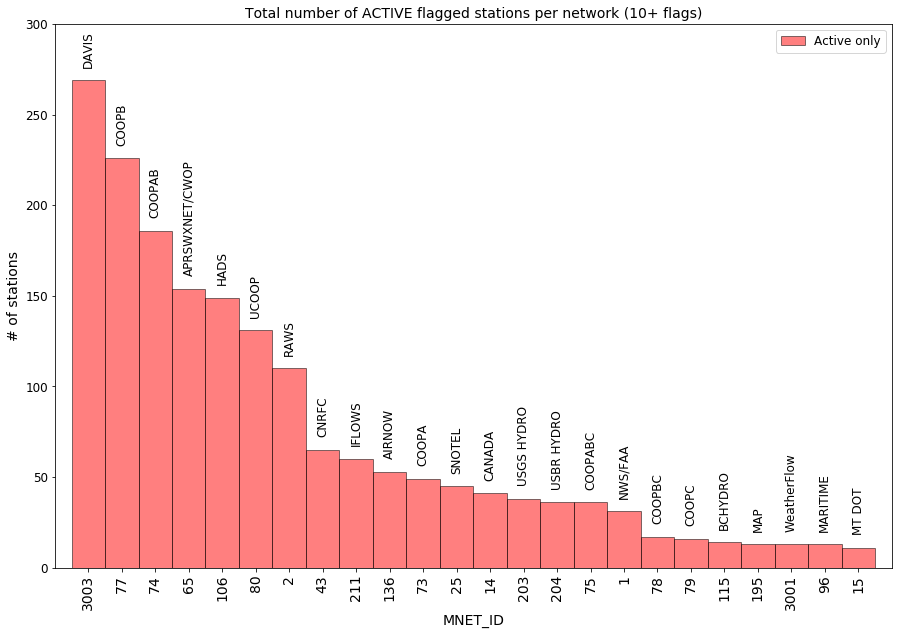

In [263]:
def autolabel(bars):
    """
    Attach a text label above each bar displaying SHORTNAME
    """
    index_pos=0
    for bar in bars:
        label = network_flags_active_limited.SHORTNAME[index_pos]
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., (height+7),
                '%s' % label,
                ha='center', va='bottom', rotation=90, fontsize=12)
        index_pos = index_pos + 1
        
fig66 = plt.figure(figsize=(15, 10))
ax1 = fig66.add_subplot(111)
bars_2 = ax1.bar(network_flags_active_limited.MNET_ID, network_flags_active_limited.flag_count,
               1, edgecolor='k', alpha=0.5, color='r', label='Active only')
ax1.set_xlabel('MNET_ID', fontsize=14)
ax1.set_ylabel('# of stations', fontsize=14)
ax1.set_title('Total number of ACTIVE flagged stations per network (10+ flags)', fontsize=14)
ax1.set_xlim([-1, len(network_flags_active_limited)])
ax1.set_ylim([0,300])
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(rotation=90)
plt.legend(fontsize=12)
        
autolabel(bars_2)
        
plt.show()

# 3. Low precision lat / lon

Analysis of stations with low precision lat and/or lon metadata (< 3 decimal places). Separate flag results for latitude and longitude are combined, with duplicate stations then removed.

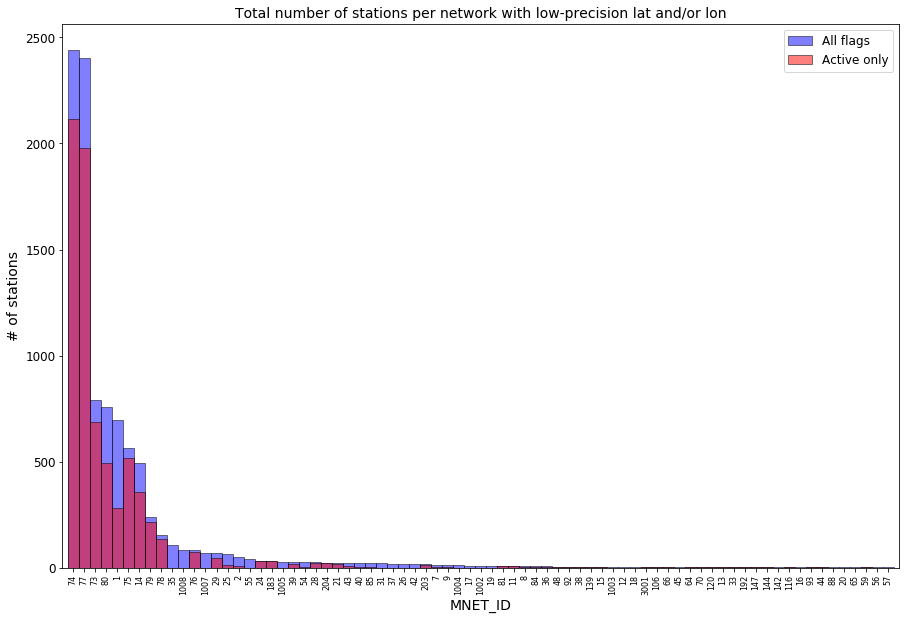

In [264]:
low_lat = pd.read_csv('csv_output/low_prec_lat.csv', sep=',', header=0)
low_lon = pd.read_csv('csv_output/low_prec_lon.csv', sep=',', header=0)

concat = pd.concat([low_lat, low_lon])
sort = concat.sort_values(by='STID')
low_prec_drop = sort.drop_duplicates(subset='STID')

network_flags = low_prec_drop.groupby(['MNET_ID','SHORTNAME']).MNET_ID.count().sort_values(ascending=False)
network_flags.rename('network_flags', inplace=True)
network_flags = network_flags.reset_index(name='flag_count')
network_flags.MNET_ID = network_flags.MNET_ID.apply(str)

low_prec_drop_active = low_prec_drop[low_prec_drop.STATUS=='ACTIVE']

network_flags_active = low_prec_drop_active.groupby(['MNET_ID','SHORTNAME']).MNET_ID.count().sort_values(ascending=False)
network_flags_active.rename('network_flags_active', inplace=True)
network_flags_active = network_flags_active.reset_index(name='flag_count')
network_flags_active.MNET_ID = network_flags_active.MNET_ID.apply(str)

fig7 = plt.figure(figsize=(15, 10))
ax1 = fig7.add_subplot(111)
bars_1 = ax1.bar(network_flags.MNET_ID, network_flags.flag_count,
               1, edgecolor='k', alpha=0.5, color='b', label='All flags')
bars_2 = ax1.bar(network_flags_active.MNET_ID, network_flags_active.flag_count,
               1, edgecolor='k', alpha=0.5, color='r', label='Active only')
ax1.set_xlabel('MNET_ID', fontsize=14)
ax1.set_ylabel('# of stations', fontsize=14)
ax1.set_title('Total number of stations per network with low-precision lat and/or lon', fontsize=14)
ax1.set_xlim([-1, len(network_flags)])
plt.xticks(fontsize=8)
plt.yticks(fontsize=12)
plt.xticks(rotation=90)
plt.legend(fontsize=12)
plt.show()

Limiting to networks with 10 flagged stations or greater:

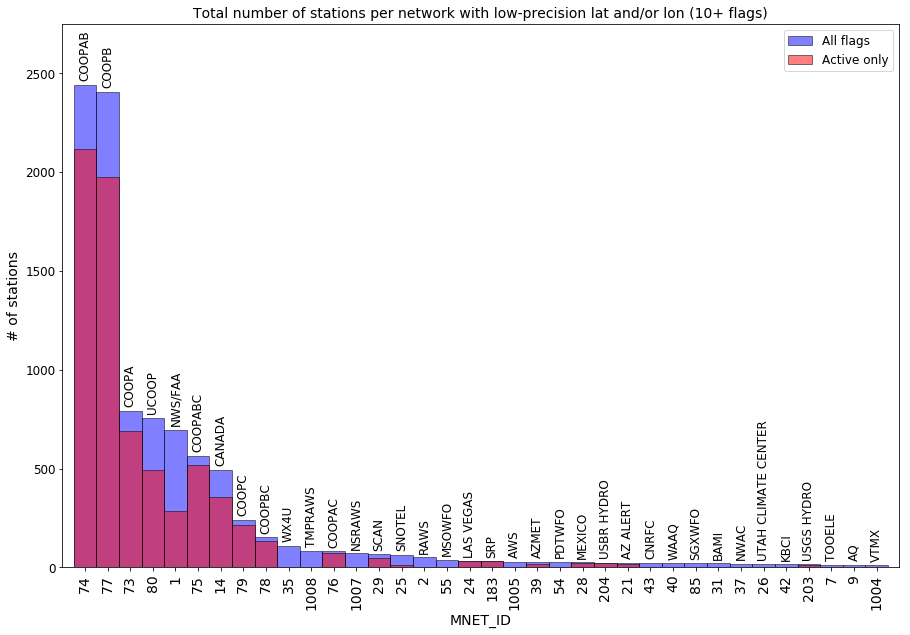

In [265]:
network_flags_limited = network_flags[network_flags.flag_count > 9]
network_flags_active_limited = network_flags_active[network_flags_active.flag_count > 9]

def autolabel(bars):
    """
    Attach a text label above each bar displaying SHORTNAME
    """
    index_pos=0
    for bar in bars:
        label = network_flags_limited.SHORTNAME[index_pos]
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., (height+20),
                '%s' % label,
                ha='center', va='bottom', rotation=90, fontsize=12)
        index_pos = index_pos + 1

fig8 = plt.figure(figsize=(15, 10))
ax1 = fig8.add_subplot(111)
bars_1 = ax1.bar(network_flags_limited.MNET_ID, network_flags_limited.flag_count,
               1, edgecolor='k', alpha=0.5, color='b', label='All flags')
bars_2 = ax1.bar(network_flags_active_limited.MNET_ID, network_flags_active_limited.flag_count,
               1, edgecolor='k', alpha=0.5, color='r', label='Active only')
ax1.set_xlabel('MNET_ID', fontsize=14)
ax1.set_ylabel('# of stations', fontsize=14)
ax1.set_title('Total number of stations per network with low-precision lat and/or lon (10+ flags)', fontsize=14)
ax1.set_xlim([-1, len(network_flags_limited)])
ax1.set_ylim([0, 2750])
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(rotation=90)
plt.legend(fontsize=12)

autolabel(bars_1)

plt.show()

Limiting to only 'ACTIVE' stations:

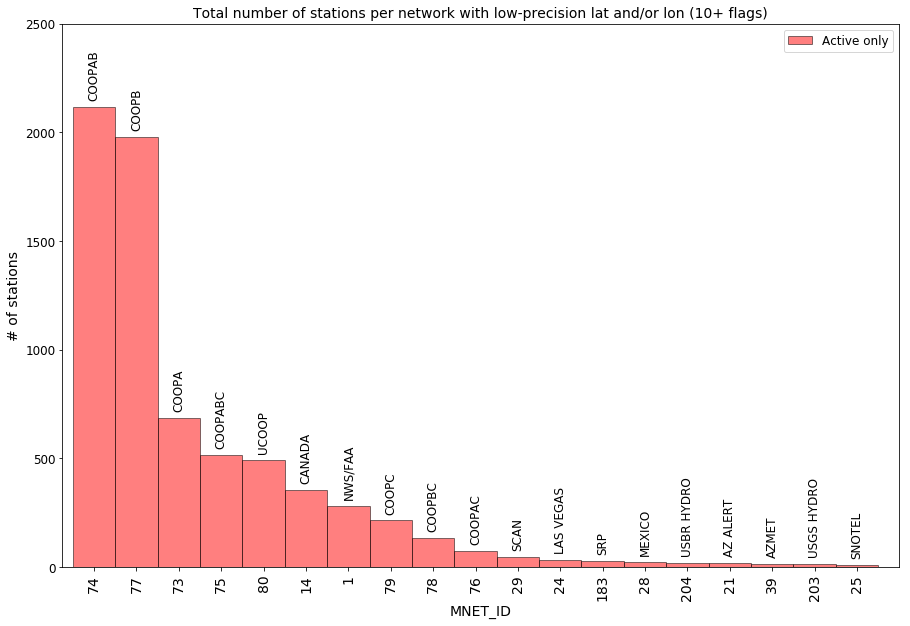

In [266]:
def autolabel(bars):
    """
    Attach a text label above each bar displaying SHORTNAME
    """
    index_pos=0
    for bar in bars:
        label = network_flags_active_limited.SHORTNAME[index_pos]
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., (height+30),
                '%s' % label,
                ha='center', va='bottom', rotation=90, fontsize=12)
        index_pos = index_pos + 1
        
fig88 = plt.figure(figsize=(15, 10))
ax1 = fig88.add_subplot(111)
bars_2 = ax1.bar(network_flags_active_limited.MNET_ID, network_flags_active_limited.flag_count,
               1, edgecolor='k', alpha=0.5, color='r', label='Active only')
ax1.set_xlabel('MNET_ID', fontsize=14)
ax1.set_ylabel('# of stations', fontsize=14)
ax1.set_title('Total number of stations per network with low-precision lat and/or lon (10+ flags)', fontsize=14)
ax1.set_xlim([-0.75, len(network_flags_active_limited)])
ax1.set_ylim([0,2500])
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(rotation=90)
plt.legend(fontsize=12)
        
autolabel(bars_2)
        
plt.show()


# 4. 'None' metadata

There are 412 stations with 'None' for elevation metadata (ACTIVE: 149). 

A single station ('UTRCH') has 'None' for STATUS. This station was dropped from the checklist.

'None' was not found for any other metadata.

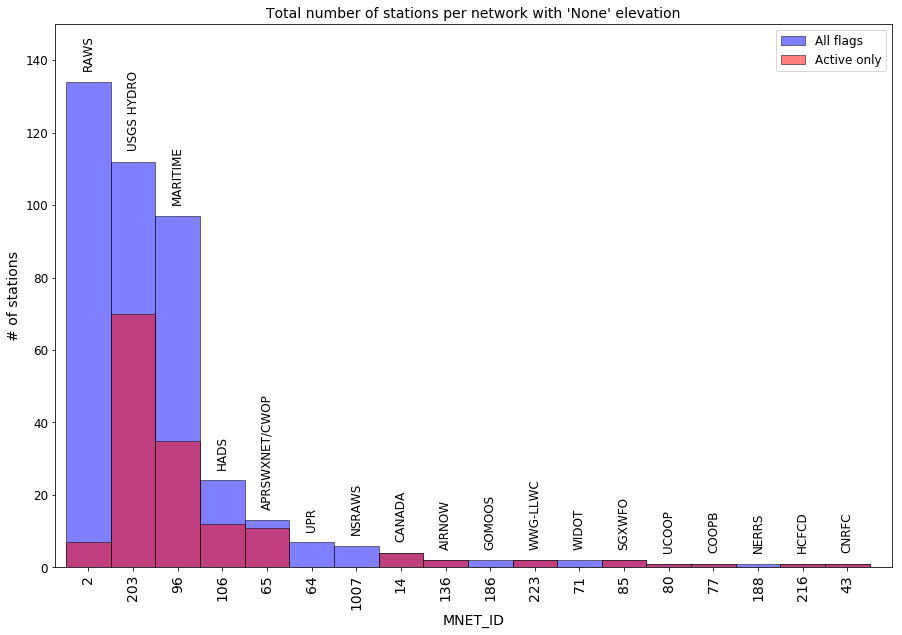

In [267]:
none_elev = pd.read_csv('csv_output/none_elev.csv', sep=',', header=0)

none_networks = none_elev.groupby(['MNET_ID', 'SHORTNAME']).MNET_ID.count().sort_values(ascending=False)
none_networks.rename('none_networks', inplace=True)
none_networks = none_networks.reset_index(name='flag_count')
none_networks.MNET_ID = none_networks.MNET_ID.apply(str)

none_elev_active = none_elev[none_elev.STATUS=='ACTIVE']

none_networks_active = none_elev_active.groupby(['MNET_ID','SHORTNAME']).MNET_ID.count().sort_values(ascending=False)
none_networks_active.rename('none_networks_active', inplace=True)
none_networks_active = none_networks_active.reset_index(name='flag_count')
none_networks_active.MNET_ID = none_networks_active.MNET_ID.apply(str)

def autolabel(bars):
    """
    Attach a text label above each bar displaying SHORTNAME
    """
    index_pos=0
    for bar in bars:
        label = none_networks.SHORTNAME[index_pos]
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., (height+3),
                '%s' % label,
                ha='center', va='bottom', rotation=90, fontsize=12)
        index_pos = index_pos + 1

fig9 = plt.figure(figsize=(15, 10))
ax1 = fig9.add_subplot(111)
bars_1 = ax1.bar(none_networks.MNET_ID, none_networks.flag_count,
               1, edgecolor='k', alpha=0.5, color='b', label='All flags')
bars_2 = ax1.bar(none_networks_active.MNET_ID, none_networks_active.flag_count,
               1, edgecolor='k', alpha=0.5, color='r', label='Active only')
ax1.set_xlabel('MNET_ID', fontsize=14)
ax1.set_ylabel('# of stations', fontsize=14)
ax1.set_title("Total number of stations per network with 'None' elevation", fontsize=14)
ax1.set_xlim([-0.75, len(none_networks)])
ax1.set_ylim([0, 150])
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(rotation=90)
plt.legend(fontsize=12)

autolabel(bars_1)
plt.show()


Limiting to only 'ACTIVE' stations:

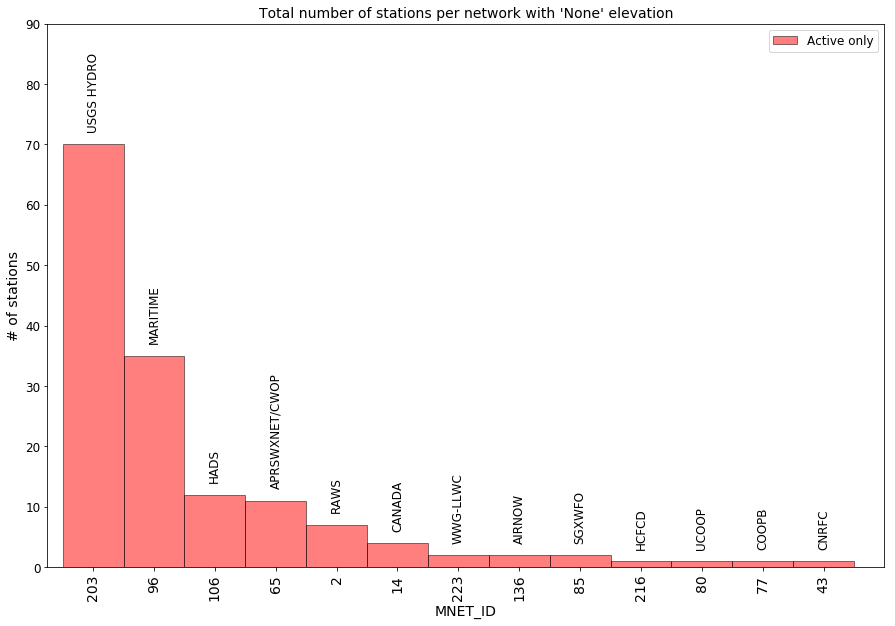

In [268]:
def autolabel(bars):
    """
    Attach a text label above each bar displaying SHORTNAME
    """
    index_pos=0
    for bar in bars:
        label = none_networks_active.SHORTNAME[index_pos]
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., (height+2),
                '%s' % label,
                ha='center', va='bottom', rotation=90, fontsize=12)
        index_pos = index_pos + 1

fig99 = plt.figure(figsize=(15, 10))
ax1 = fig99.add_subplot(111)
bars_2 = ax1.bar(none_networks_active.MNET_ID, none_networks_active.flag_count,
               1, edgecolor='k', alpha=0.5, color='r', label='Active only')
ax1.set_xlabel('MNET_ID', fontsize=14)
ax1.set_ylabel('# of stations', fontsize=14)
ax1.set_title("Total number of stations per network with 'None' elevation", fontsize=14)
ax1.set_xlim([-0.75, len(none_networks_active)])
ax1.set_ylim([0, 90])
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(rotation=90)
plt.legend(fontsize=12)

autolabel(bars_2)
plt.show()

# 5. Outlier stations

Outlier stations not displayed in the first elevation flag histogram (n=96). Elevation differences > (+/-) 5000', sorted by 'MNET_ID'.

**'ACTIVE':**

In [269]:
pd.options.display.max_rows = 100
display(outliers_sort_MNET_ID[outliers_sort_MNET_ID.STATUS=='ACTIVE'])

ID       STID  MNET_ID       SHORTNAME        lat         lon  \
234   13134      AZPA3        2            RAWS  35.877386 -113.178403   
3214   3332      SRAC2        2            RAWS  39.510992 -105.537442   
880   53663  COOPGCRC2        7          TOOELE  39.650000 -105.700000   
1108  54237  COOPMLBH1        7          TOOELE  19.540000 -155.580000   
746   53627  COOPCLXC2        7          TOOELE  39.380000 -106.200000   
3216  65097      SROC1       43           CNRFC  33.546110 -115.470280   
1527  41162      CQ254       57            CARB  37.645760 -118.966540   
2456  63504      F1647       65  APRSWXNET/CWOP  50.735830 -113.931170   
882   53666  COOPGDPC2       74          COOPAB  38.950000 -109.050000   
725   53617  COOPCCRC2       74          COOPAB  38.450000 -106.760000   
1491  53798  COOPYMPC2       74          COOPAB  40.160000 -106.910000   
966   53694  COOPIGCC2       74          COOPAB  37.090000 -107.530000   
1066  53721    COOPLXV       74          COOPAB  39.230000 -106.320000   
1100  54570  COOPMHSI1       74          COOPAB  42.030000 -115.350000   
1118  58507  COOPMNLT2       74          COOPAB  32.750000   95.490000   
784   57708  COOPCVWP1       75         COOPABC  41.930000   79.300000   
935   55047  COOPHMBK1       78          COOPBC  37.820000  -95.450000   
788   59421  COOPCYSW4       78          COOPBC  41.150000 -104.810000   
1037  53707  COOPLGEC2       80           UCOOP  38.990000 -105.370000   
1044  53713  COOPLKEC2       80           UCOOP  39.680000 -105.070000   
907   53681  COOPGUXC2       80           UCOOP  38.520000 -107.000000   
818   53650  COOPEAGC2       80           UCOOP  39.630000 -104.800000   
805   53646  COOPDROC2       80           UCOOP  37.310000 -107.840000   
763   53633  COOPCOSC2       80           UCOOP  38.830000 -104.820000   
754   53630  COOPCNNC2       80           UCOOP  38.430000 -105.270000   
1202  53741  COOPPAKC2       80           UCOOP  39.550000 -104.730000   
681   53598  COOPBGGC2       80           UCOOP  41.000000 -107.540000   
656   53592  COOPASIC2       80           UCOOP  39.830000 -105.480000   
1208  53742  COOPPARC2       80           UCOOP  38.400000 -108.960000   
1279  53751  COOPROSC2       80           UCOOP  38.100000 -105.350000   
1413  53777  COOPURYC2       80           UCOOP  38.030000 -107.670000   
12    62305      41117       96        MARITIME  30.000000  -81.100000   
2689  59750      KING1      106            HADS  30.956670  -82.137500   
2976  44791      OBCN7      106            HADS  36.374440  -75.834170   
3454  44988  USGSHY105      203      USGS HYDRO  40.759670 -111.564091   
3457  44992  USGSHY109      203      USGS HYDRO  38.627752 -111.647965   
3502  44975   USGSHY92      203      USGS HYDRO  40.606612 -110.527107   
3472  45209  USGSHY326      203      USGS HYDRO  25.709660  -80.251720   
2478  46840       FLGY      204      USBR HYDRO  44.098889 -110.667222   
1932  65373   DVI00067     3003           DAVIS  38.324620 -122.119350   
2154  69887   DVI04560     3003           DAVIS  37.636490 -122.126060   
2145  69752   DVI04425     3003           DAVIS  38.123160 -110.814750   
2079  68185   DVI02858     3003           DAVIS  40.177580 -110.294880   
2047  67525   DVI02198     3003           DAVIS  42.776210 -103.994200   
2120  69258   DVI03931     3003           DAVIS  37.636490 -122.126060   
1984  66229   DVI00902     3003           DAVIS  39.448920 -106.040770   

         elev  DEM_elev  elev_diff  STATUS  
234      63.0    6361.5    -6298.5  ACTIVE  
3214   2760.0    9091.2    -6331.2  ACTIVE  
880    1002.0   11266.4   -10264.4  ACTIVE  
1108   1115.0   10882.5    -9767.5  ACTIVE  
746    1132.0   11453.4   -10321.4  ACTIVE  
3216   7400.0    2027.6     5372.4  ACTIVE  
1527   2402.0    7844.5    -5442.5  ACTIVE  
2456  11732.0    3569.6     8162.4  ACTIVE  
882       0.0    6381.2    -6381.2  ACTIVE  
725       0.0    8018.4    -8018.4  ACTIVE  
1491      0.0    7837.9    -7837.9 

**'INACTIVE':**

In [270]:
pd.options.display.max_rows = 100
display(outliers_sort_MNET_ID[outliers_sort_MNET_ID.STATUS=='INACTIVE'])

ID       STID  MNET_ID       SHORTNAME        lat        lon  \
2708  29304       KO45        1         NWS/FAA  38.380000 -120.05000   
3330   3206      TR076        2            RAWS   0.000000    0.00000   
3371   5704      TR632        2            RAWS  19.821100 -155.33060   
3434  40539      TT240        2            RAWS   0.000000    0.00000   
3396  13584      TS449        2            RAWS   0.000000    0.00000   
3367   2426      TR599        2            RAWS  35.760800  -75.85220   
248    2933      BCI16       42            KBCI  44.250000 -116.97000   
1877  31413      D8341       65  APRSWXNET/CWOP  35.200330 -113.07950   
1802  29268      D6040       65  APRSWXNET/CWOP  39.912830   74.07783   
2380  48077      E8431       65  APRSWXNET/CWOP  32.294500 -104.10000   
218   33943      AU434       65  APRSWXNET/CWOP  30.147170  101.32500   
196   25119      AT091       65  APRSWXNET/CWOP  35.746330   79.10917   
2406  60534      E9635       65  APRSWXNET/CWOP  46.657170 -112.02850   
164   10267      AR352       65  APRSWXNET/CWOP  40.866670 -115.95000   
187   15638      AS159       65  APRSWXNET/CWOP  32.518000   98.04600   
221   40215      AU694       65  APRSWXNET/CWOP  41.451670  -80.40050   
387   11365      C2196       65  APRSWXNET/CWOP  35.645300 -118.35550   
448   14804      C4620       65  APRSWXNET/CWOP  40.285800 -110.06170   
455   15658      C4962       65  APRSWXNET/CWOP  37.483300 -119.88330   
497   17617      C6742       65  APRSWXNET/CWOP  36.300000 -115.20000   
561   23096      C9902       65  APRSWXNET/CWOP  43.916670 -116.23333   
2397  52589      E9122       65  APRSWXNET/CWOP  34.096000 -116.40000   
1743  26728      D3933       65  APRSWXNET/CWOP  39.841830 -121.60167   
1853  30757      D7683       65  APRSWXNET/CWOP  35.978500 -114.83017   
2223  36106      E0666       65  APRSWXNET/CWOP  40.000000 -105.27550   
2238  42024      E1421       65  APRSWXNET/CWOP  37.502500  112.63800   
2356  46438      E7474       65  APRSWXNET/CWOP  36.471330 -108.25083   
2368  47378      E7947       65  APRSWXNET/CWOP  38.640500 -112.16567   
1804  29363      D6166       65  APRSWXNET/CWOP  48.204670 -114.38933   
933   58413  COOPHLRT2       74          COOPAB  32.730000   95.19000   
928   57969  COOPHILS2       80           UCOOP  43.930000 -103.50000   
1359  53768  COOPSTBC2       80           UCOOP  40.470000 -106.81000   
1271  53748  COOPRLVC2       80           UCOOP  39.920000 -105.51000   
1322  53765  COOPSIAC2       80           UCOOP  39.360000 -104.93000   
1355  60372    COOPSRR       80           UCOOP  33.470000 -105.53000   
1137  53730  COOPMRSC2       80           UCOOP  39.620000 -105.18000   
1473  53791  COOPWSAC2       80           UCOOP  37.483300 -106.79100   
768   53635  COOPCRHC2       80           UCOOP  39.420000 -105.45000   
1157  53735  COOPNDLC2       80           UCOOP  39.960000 -105.52000   
137   40208      ANDC2      106            HADS  40.289720 -105.66694   
2810  44017      MGLM3      106            HADS  42.637500  -73.16778   
103   28163      AN260      136          AIRNOW  45.215800  -68.70820   
3464  45082  USGSHY199      203      USGS HYDRO  21.289720 -157.73333   
3466  44904   USGSHY21      203      USGS HYDRO  30.448020  -90.35944   
3499  44967   USGSHY84      203      USGS HYDRO   0.000000    0.00000   
3480  44927   USGSHY44      203      USGS HYDRO  40.200231  -63.14000   
2907   3504      NS032     1007          NSRAWS   0.000000    0.00000   
2897   3474      NS002     1007          NSRAWS   0.000000    0.00000   
2902   3488      NS016     1007          NSRAWS  46.166900 -115.16690   
3301   1877      TMPD0     1008         TMPRAWS  48.170000 -118.71000   

         elev  DEM_elev  elev_diff    STATUS  
2708    108.0    6666.7    -6558.7  INACTIVE  
3330   7100.0       0.0     7100.0  INACTIVE  
3371     66.0    6410.8    -6344.8  INACTIVE  
3434   6060.0       0.0     6060.0  INACTIVE  
3396   5300.0       0.0     5300.0  INACTIVE  
336